Integrantes:

Oscar Guzmán

*   Oscar Guzmán
*   Carlos Cueva

Correo del profe: jmcursosingenieria111@gmail.com

Ejercicios y Problemas.  

1. Con base en la figura 6.1, tome una ecuación determinada, por ejemplo una raíz cuadrada o cúbica, o un seno, genere un data set con muchos valores. Usando una herramienta de ML, encuentre el resultado de un determinado valor.

2. Diseñe e implemente un sistema de almacenamiento de datos, para la entrada de
productos para una pequeña bodega, utilizando la voz. Ver el siguiente link:
https://cloud.google.com/speech-to-text/pricing.

3. Desarrolle un problema de su escogencia.


**Problema 1**  
Con base en la figura 6.1, tome una ecuación determinada, por ejemplo una raíz cuadrada o cúbica, o un seno, genere un data set con muchos valores. Usando una herramienta de ML, encuentre el resultado de un determinado valor.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
X = np.linspace(0, 2 * np.pi, 1000).reshape(-1, 1)
y = np.sin(X).ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(1,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=0)

In [ ]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

7/7 [==============================] - 0s 4ms/step
Mean Squared Error: 1.764149313822542e-05


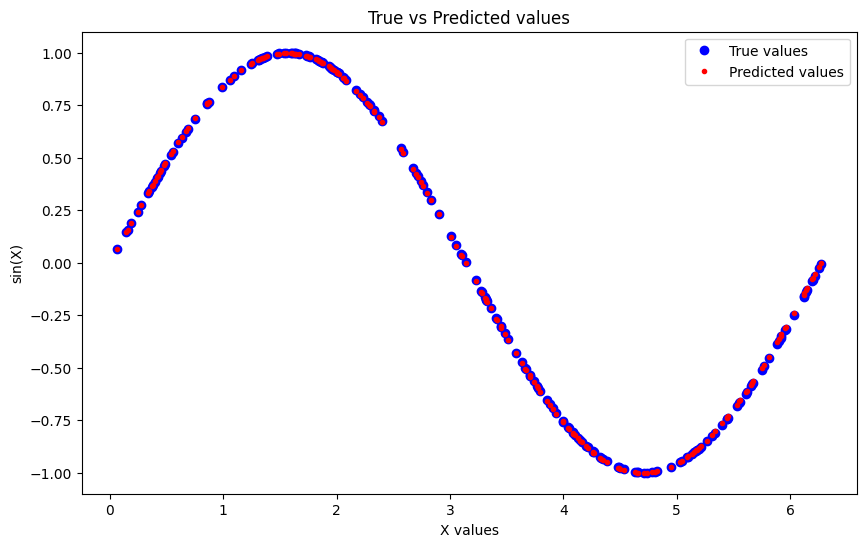

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, 'bo', label='True values')  # Corregir aquí
plt.plot(X_test, y_pred, 'r.', label='Predicted values')  # Corregir aquí
plt.legend()
plt.xlabel('X values')
plt.ylabel('sin(X)')
plt.title('True vs Predicted values')
plt.show()

In [ ]:
value_to_predict = np.array([[np.pi / 4]])
value_to_predict_scaled = scaler.transform(value_to_predict)
predicted_value = model.predict(value_to_predict_scaled)
print(f'Predicted value for sin(pi/4): {predicted_value[0][0]}')

1/1 [==============================] - 0s 40ms/step
Predicted value for sin(pi/4): 0.7104774117469788


**Pregunta 2**  

Diseñe e implemente un sistema de almacenamiento de datos, para la entrada de
productos para una pequeña bodega, utilizando la voz. Ver el siguiente link:
https://cloud.google.com/speech-to-text/pricing.


se define la base de datos inicial

In [ ]:
import sqlite3
import random
from inflect import engine

In [ ]:
# Inicializar la base de datos y poblarla con algunos productos iniciales
def init_db():
    conn = sqlite3.connect('bodega.db')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS productos
                      (producto TEXT, marca TEXT, caracteristica TEXT, medida TEXT, cantidad INTEGER)''')
    cursor.execute('SELECT COUNT(*) FROM productos')
    if cursor.fetchone()[0] == 0:
        productos_iniciales = [
            ("leche", "gloria", "deslactosada", "un tarro", 10),
            ("jabon", "dove", "suave", "una barra", 5),
            ("pasta", "maruchan", "instantanea", "un sobre", 8),
            ("aceite", "capri", "vegetal", "un litro", 15)
        ]
        for producto in productos_iniciales:
            cursor.execute('INSERT INTO productos (producto, marca, caracteristica, medida, cantidad) VALUES (?, ?, ?, ?, ?)', (*producto,))
    conn.commit()
    return conn

se instala las librerías necesarias para y se defines necesarias modificar la tabla dependiendo los productos

In [ ]:
!apt-get install ffmpeg
!pip install SpeechRecognition
!pip install pydub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import speech_recognition as sr
from pydub import AudioSegment
from google.colab import files

In [ ]:
def convert_ogg_to_wav(ogg_path, wav_path):
    audio = AudioSegment.from_ogg(ogg_path)
    audio.export(wav_path, format="wav")

def transcribe_audio(file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
    try:
        transcription = recognizer.recognize_google(audio, language="es-ES")
        transcription = unidecode.unidecode(transcription)  # Normalize transcription
        print("Transcription: {}".format(transcription))
        return transcription
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
        return ""
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))
        return ""

In [ ]:
def parse_product_details(transcription):
    details = transcription.lower().split()
    if len(details) < 4:
        return None
    producto = details[0]
    marca = details[1]
    caracteristica = details[2]
    medida = " ".join(details[3:])
    return producto, marca, caracteristica, medida

def agregar_o_actualizar_producto(conn, new_product):
    if not new_product:
        print("Error: Producto no válido")
        return

    cursor = conn.cursor()
    cursor.execute('SELECT * FROM productos')
    productos = cursor.fetchall()

    producto_existente = False
    for producto in productos:
        if producto[:4] == new_product:
            nueva_cantidad = producto[4] + 1
            cursor.execute('UPDATE productos SET cantidad=? WHERE producto=? AND marca=? AND caracteristica=? AND medida=?', (nueva_cantidad, *new_product))
            producto_existente = True
            break

    if not producto_existente:
        cursor.execute('INSERT INTO productos (producto, marca, caracteristica, medida, cantidad) VALUES (?, ?, ?, ?, ?)', (*new_product, 1))

    conn.commit()

se crean la funciones necesarias para que el usuario pueda ejecutar la tabla  


*   **cargar_audio()** se encarga de insertar un audio ogg (formato de whatsapp) y lo transforma en una cadena de texto para ser añadido en la tabla con el siguiente formato producto (1 palabra), marca (1 palabra), característica (1 palabra) y medida con el resto de palabras. Si el producto ya existe se añade +1 a la cantidad del producto y si es un producto nuevo se añade al final de la base de datos
*   **mostrar_datos()** se encarga de imprimir el estado instantáneo de la tabla dependiendo de la base de datos y el formato establecido



In [ ]:
!pip install unidecode
!pip install tabulate

In [ ]:
import unidecode
from tabulate import tabulate

In [ ]:
def cargar_audio():
    uploaded = files.upload()
    ogg_path = list(uploaded.keys())[0]
    wav_path = ogg_path.replace('.ogg', '.wav')
    convert_ogg_to_wav(ogg_path, wav_path)
    transcription = transcribe_audio(wav_path)
    new_product = parse_product_details(transcription)
    conn = sqlite3.connect('bodega.db')
    agregar_o_actualizar_producto(conn, new_product)
    conn.close()

In [ ]:
def mostrar_datos():
    conn = sqlite3.connect('bodega.db')
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM productos')
    rows = cursor.fetchall()
    headers = ["Producto", "Marca", "Característica", "Medida", "Cantidad"]
    table = tabulate(rows, headers=headers, tablefmt='pretty')
    print(table)
    conn.close()

In [ ]:
init_db()

In [ ]:
mostrar_datos()

+----------+----------+----------------+-----------+----------+
| Producto |  Marca   | Característica |  Medida   | Cantidad |
+----------+----------+----------------+-----------+----------+
|  leche   |  gloria  |  deslactosada  | un tarro  |    10    |
|  jabon   |   dove   |     suave      | una barra |    5     |
|  pasta   | maruchan |  instantanea   | un sobre  |    8     |
|  aceite  |  capri   |    vegetal     | un litro  |    15    |
+----------+----------+----------------+-----------+----------+


In [ ]:
cargar_audio()

Saving WhatsApp Ptt 2024-06-26 at 8.46.51 PM.ogg to WhatsApp Ptt 2024-06-26 at 8.46.51 PM.ogg
Transcription: leche Gloria deslactosada un tarro


In [ ]:
mostrar_datos()

+----------+----------+----------------+-----------+----------+
| Producto |  Marca   | Característica |  Medida   | Cantidad |
+----------+----------+----------------+-----------+----------+
|  leche   |  gloria  |  deslactosada  | un tarro  |    11    |
|  jabon   |   dove   |     suave      | una barra |    5     |
|  pasta   | maruchan |  instantanea   | un sobre  |    8     |
|  aceite  |  capri   |    vegetal     | un litro  |    15    |
+----------+----------+----------------+-----------+----------+


In [ ]:
cargar_audio()

Saving WhatsApp Ptt 2024-06-26 at 8.46.59 PM.ogg to WhatsApp Ptt 2024-06-26 at 8.46.59 PM.ogg
Transcription: jabon Dove suave una barra


In [ ]:
mostrar_datos()

+----------+----------+----------------+-----------+----------+
| Producto |  Marca   | Característica |  Medida   | Cantidad |
+----------+----------+----------------+-----------+----------+
|  leche   |  gloria  |  deslactosada  | un tarro  |    11    |
|  jabon   |   dove   |     suave      | una barra |    6     |
|  pasta   | maruchan |  instantanea   | un sobre  |    8     |
|  aceite  |  capri   |    vegetal     | un litro  |    15    |
+----------+----------+----------------+-----------+----------+


In [ ]:
cargar_audio()

Saving WhatsApp Ptt 2024-06-26 at 8.47.42 PM.ogg to WhatsApp Ptt 2024-06-26 at 8.47.42 PM.ogg
Transcription: detergente hace floral 220 G


In [ ]:
mostrar_datos()

+------------+----------+----------------+-----------+----------+
|  Producto  |  Marca   | Característica |  Medida   | Cantidad |
+------------+----------+----------------+-----------+----------+
|   leche    |  gloria  |  deslactosada  | un tarro  |    11    |
|   jabon    |   dove   |     suave      | una barra |    6     |
|   pasta    | maruchan |  instantanea   | un sobre  |    8     |
|   aceite   |  capri   |    vegetal     | un litro  |    15    |
| detergente |   hace   |     floral     |   220 g   |    1     |
+------------+----------+----------------+-----------+----------+


In [ ]:
cargar_audio()

Saving WhatsApp Ptt 2024-06-26 at 8.48.15 PM.ogg to WhatsApp Ptt 2024-06-26 at 8.48.15 PM.ogg
Transcription: jabon Bolivar limon una barra


In [ ]:
mostrar_datos()

+------------+----------+----------------+-----------+----------+
|  Producto  |  Marca   | Característica |  Medida   | Cantidad |
+------------+----------+----------------+-----------+----------+
|   leche    |  gloria  |  deslactosada  | un tarro  |    11    |
|   jabon    |   dove   |     suave      | una barra |    6     |
|   pasta    | maruchan |  instantanea   | un sobre  |    8     |
|   aceite   |  capri   |    vegetal     | un litro  |    15    |
| detergente |   hace   |     floral     |   220 g   |    1     |
|   jabon    | bolivar  |     limon      | una barra |    1     |
+------------+----------+----------------+-----------+----------+


**Problema 3**  
se propuso un problema  
Desarrollar un sistema de recomendación de películas utilizando técnicas de factorización matricial. Este sistema deberá predecir las calificaciones que los usuarios darían a películas que no han visto y proporcionar una lista de recomendaciones personalizadas.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Definir las columnas para los archivos de datos
columns_ratings = ['UserID', 'MovieID', 'Rating', 'Timestamp']
columns_movies = ['MovieID', 'Title', 'Genres']

# Leer los datos
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=columns_ratings, encoding='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep='|', names=columns_movies, encoding='latin-1', usecols=[0, 1, 2])

# Merge ratings and movies dataframes
data = pd.merge(ratings, movies, on='MovieID')

# Drop unnecessary columns
data = data.drop(['Timestamp', 'Genres'], axis=1)

# Ajustar los IDs para que comiencen desde 0
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

data['UserID'] = user_encoder.fit_transform(data['UserID'])
data['MovieID'] = movie_encoder.fit_transform(data['MovieID'])


In [ ]:
# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Get the number of unique users and movies
num_users = data['UserID'].nunique()
num_movies = data['MovieID'].nunique()

print(f'Number of unique users: {num_users}')
print(f'Number of unique movies: {num_movies}')

Number of unique users: 943
Number of unique movies: 1682


In [ ]:
# Definir el tamaño de los vectores de embedding
embedding_size = 50

# Crear las capas de entrada
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Crear las capas de embedding
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)

# Aplanar los vectores de embedding
user_vecs = Flatten()(user_embedding)
movie_vecs = Flatten()(movie_embedding)

# Calcular el producto punto entre las dos capas de embedding
y = Dot(axes=1)([user_vecs, movie_vecs])

# Crear el modelo de factorización matricial
model = Model(inputs=[user_input, movie_input], outputs=y)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Resumen del modelo
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                47150     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 50)                84100     ['movie_input[0][0]']         
 )                                                                                          

In [ ]:
# Entrenar el modelo
history = model.fit(
    [train['UserID'], train['MovieID']],
    train['Rating'],
    epochs=10,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/10
1125/1125 [==============================] - 6s 4ms/step - loss: 9.8482 - val_loss: 2.4890
Epoch 2/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4590 - val_loss: 1.1019
Epoch 3/10
1125/1125 [==============================] - 4s 4ms/step - loss: 0.9604 - val_loss: 0.9695
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8706 - val_loss: 0.9315
Epoch 5/10
1125/1125 [==============================] - 5s 4ms/step - loss: 0.8201 - val_loss: 0.9081
Epoch 6/10
1125/1125 [==============================] - 5s 4ms/step - loss: 0.7783 - val_loss: 0.8978
Epoch 7/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7386 - val_loss: 0.8849
Epoch 8/10
1125/1125 [==============================] - 5s 4ms/step - loss: 0.7014 - val_loss: 0.8801
Epoch 9/10
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6645 - val_loss: 0.8719
Epoch 10/10
1125/1125 [==============================] - 6s 6ms/step - loss: 0.62

625/625 [==============================] - 1s 1ms/step - loss: 0.8805
Test Loss: 0.8805


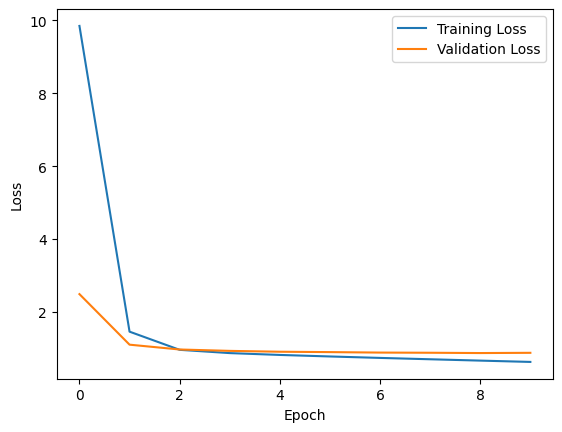

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate([test['UserID'], test['MovieID']], test['Rating'])
print(f'Test Loss: {test_loss:.4f}')

# Graficar el historial de entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Función para hacer recomendaciones a un usuario específico
def recommend_movies(user_id, num_recommendations=10):
    # Obtener todas las películas que el usuario no ha visto
    user_seen_movies = data[data['UserID'] == user_id]['MovieID']
    unseen_movies = data[~data['MovieID'].isin(user_seen_movies)]['MovieID'].unique()

    # Predecir las calificaciones para todas las películas no vistas
    predicted_ratings = []
    for movie_id in unseen_movies:
        predicted_rating = model.predict([np.array([user_id]), np.array([movie_id])])
        predicted_ratings.append((movie_id, predicted_rating))

    # Ordenar las películas por calificación predicha
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    # Obtener las mejores recomendaciones
    top_recommendations = predicted_ratings[:num_recommendations]

    # Obtener los títulos de las películas recomendadas
    recommended_movies = [movies[movies['MovieID'] == movie_encoder.inverse_transform([movie_id])[0]]['Title'].values[0] for movie_id, _ in top_recommendations]

    return recommended_movies

# Hacer recomendaciones para un usuario específico
user_id = 1
recommendations = recommend_movies(user_id)
print(f'Recommendations for User {user_id}:')
for i, movie in enumerate(recommendations, 1):
    print(f'{i}. {movie}')

1/1 [==============================] - 0s 22ms/step
Recommendations for User 1:
1. Pather Panchali (1955)
2. Dangerous Beauty (1998)
3. Maya Lin: A Strong Clear Vision (1994)
4. Close Shave, A (1995)
5. Faust (1994)
6. Mrs. Dalloway (1997)
7. Schindler's List (1993)
8. Casablanca (1942)
9. Priest (1994)
10. Third Man, The (1949)
